In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

params = {"axes.labelsize": 14,
          "axes.titlesize": 16,}
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update(params)

def place(ax):
  ax.tick_params(direction="in", which="minor", length=3)
  ax.tick_params(direction="in", which="major", length=5, labelsize=13)
  ax.grid(which="major", ls="dashed", dashes=(1, 3), lw=0.8, zorder=0)
  fig.tight_layout()



def combine_data(xbins, rho_O, rho_H, mu_O, mu_H, 
                 muloc_O, muloc_H, c1_O, c1_H):
    data = {}
    
    data = np.zeros(xbins.shape, dtype=[('xbins', 'f8'),
                                        ('rho_O', 'f8'), ('muloc_O', 'f8'), ('c1_O', 'f8'), ('mu_O', 'f8'),
                                        ('rho_H', 'f8'), ('muloc_H', 'f8'), ('c1_H', 'f8'), ('mu_H', 'f8'),
                                        ('elec_O', 'f8'), ('elec_H', 'f8')])
    
    data['xbins'] = xbins
    data['rho_O'] = rho_O
    data['rho_H'] = rho_H
    data['mu_O'] = mu_O
    data['mu_H'] = mu_H
    data['muloc_O'] = muloc_O
    data['muloc_H'] = muloc_H
    data['c1_O'] = c1_O
    data['c1_H'] = c1_H
    return data

# Load the simData dictionary from the file
simData_Efield = np.load("../../data/edl_SR.npy", allow_pickle=True).item()
simData_all = np.load("../../data/RPM_all_Aug20.npy", allow_pickle=True).item()

simData = {}

for key in ['training', 'validation', 'test']:
    # Combine the inner dictionaries
    simData[key] = { **simData_all.get(key, {}), **simData_Efield.get(key, {}) }


# Combine all simulations into one list
all_simulations = []
for category in ['training', 'validation', 'test']:
    all_simulations.extend(list(simData[category].keys()))
    
    

for sim in all_simulations:
    category = next(cat for cat in simData if sim in simData[cat])
    data = simData[category][sim]
    xbins = data['xbins']
    rho_O =  np.flip(data['rho_O'])
    muloc_O = np.flip(data['muloc_O'])
    c1_O = np.flip(data['c1_O'])
    rho_H = np.flip(data['rho_H'])
    muloc_H = np.flip(data['muloc_H'])
    c1_H = np.flip(data['c1_H'])
    mu_H = np.flip(data['mu_H'])
    mu_O = np.flip(data['mu_O'])
    
    sim_name = sim + "_mirror"
    combined_data_mirror = combine_data(xbins, rho_O, rho_H, mu_O, mu_H,
                                    muloc_O, muloc_H, c1_O, c1_H,)
    
    simData[category][sim_name] = combined_data_mirror
    
    

all_simulations = []
for category in ['training', 'validation', 'test']:
    all_simulations.extend(list(simData[category].keys()))
    

print(len(all_simulations))

5202


## Inspect the data

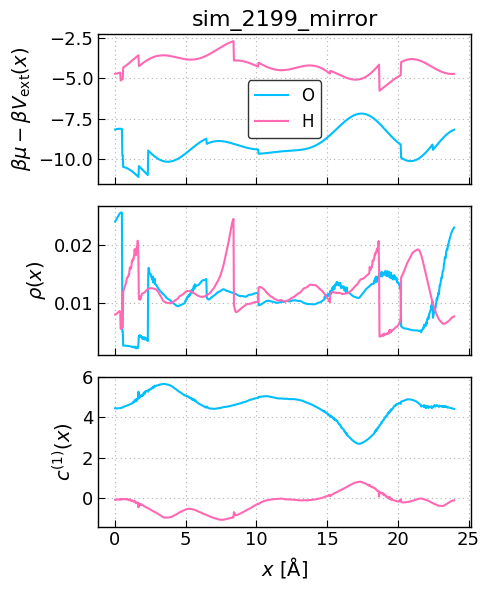

In [11]:
# Select a random simulation
random_sim = random.choice(all_simulations)
# Determine which category the random simulation belongs to
category = next(cat for cat in simData if random_sim in simData[cat])


# Get the data for the random simulation
data = simData[category][random_sim]

# Extract z, rho, muloc, and c1
xbins = data['xbins']

rho_O = data['rho_O']
muloc_O = data['muloc_O']
c1_O = data['c1_O']
rho_H = data['rho_H']
muloc_H = data['muloc_H']
c1_H = data['c1_H']


# Plot muloc(z), rho(z), and c1(z)
fig, ax = plt.subplots(3, 1, figsize=(5,6), sharex='all')


ax[0].plot(xbins, muloc_O, label='O', color='deepskyblue')
ax[0].plot(xbins, muloc_H, label='H', color='hotpink')

ax[0].set_ylabel(r'$\beta\mu - \beta V_{\mathrm{ext}}(x)$')
ax[0].set_title(f'{random_sim}')

ax[1].plot(xbins, rho_O, label='O', color='deepskyblue')
ax[1].plot(xbins, rho_H, label='H', color='hotpink')
ax[1].set_ylabel(r'$\rho(x)$')


ax[2].plot(xbins, c1_O, label='O', color='deepskyblue')
ax[2].plot(xbins, c1_H, label='H', color='hotpink')
ax[2].set_ylabel(r'$c^{(1)}(x)$')
ax[2].set_xlabel(r'$x$ [$\mathrm{\AA}$]')
ax[0].legend(frameon=True, loc="best", fontsize=12,edgecolor="black")
#ax[2].set_xlim(0, 20)

place(ax[1])
place(ax[0])
place(ax[2])

plt.show()

## Curate data for training, sliding window approach

In [12]:
import sys
sys.path.append("..")
from data_generators import DataGeneratorTwoType

# Generator options
generatorOptions = {
    "batch_size": 128,
    "windowSigma": 10.00,
    "inputKeys1": ["rho_H"],
    "inputKeys2": ["rho_O"],
    "outputKeys": ["c1_H"],
    "binKey": "xbins",
}

# Create data generators
trainingGenerator = DataGeneratorTwoType(simData["training"], **generatorOptions)
validationGenerator = DataGeneratorTwoType(simData["validation"], **generatorOptions)


2024-11-25 16:27:43.956617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 16:27:43.996121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialized DataGenerator with 3166 simulations,
yielding up to 2544590 samples in batches of 128
Initialized DataGenerator with 1036 simulations,
yielding up to 834378 samples in batches of 128


## Create neural network for model

2024-11-25 16:31:34.747149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ rho_H (InputLayer)  │ (None, 667, 1)    │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rho_O (InputLayer)  │ (None, 667, 1)    │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten (Flatten)   │ (None, 667)       │       0 │ rho_H[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten_1 (Flatten) │ (None, 667)       │       0 │ rho_O[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 1334)      │       0 │ flatten[0][0],       │
│ (Concatenate)       │                   │         │ flatten_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 512)       │ 683,520 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │ 262,656 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │ 262,656 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ c1_H (Dense)        │ (None, 1)         │     513 │ dense_2[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 1,209,345 (4.61 MB)

 Trainable params: 1,209,345 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

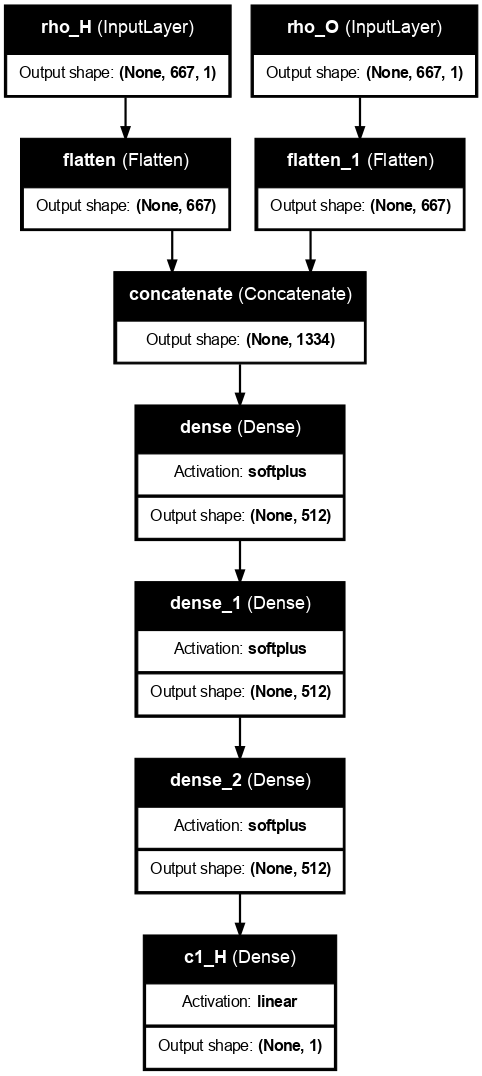

In [13]:
from tensorflow import keras

# Define the model inputs
rho_H_input = keras.Input(shape=trainingGenerator.input1Shape, name="rho_H")
rho_O_input = keras.Input(shape=trainingGenerator.input2Shape, name="rho_O")

# Flatten array
x_H = keras.layers.Flatten()(rho_H_input)
x_O = keras.layers.Flatten()(rho_O_input)

# Concatenate the two inputs
x = keras.layers.Concatenate()([x_H, x_O])
x = keras.layers.Dense(512, activation="softplus")(x)
x = keras.layers.Dense(512, activation="softplus")(x)
x = keras.layers.Dense(512, activation="softplus")(x)

# learn the c1_H
output = keras.layers.Dense(trainingGenerator.outputShape[0], name="c1_H")(x)

model = keras.Model(inputs=[rho_H_input, rho_O_input], outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()]
)
model.summary()

keras.utils.plot_model(model, show_shapes=True, show_layer_names=True ,show_layer_activations=True, dpi=80, to_file='model_RPM_H.png')


## Train neural network

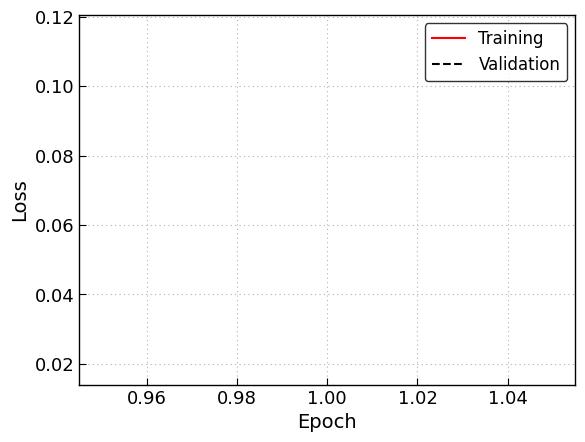

19879/19879 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 0.4005 - mean_absolute_error: 0.3543 - val_loss: 0.0189 - val_mean_absolute_error: 0.1159 - learning_rate: 0.0010
Epoch 2/400
 4313/19879 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 0.0170 - mean_absolute_error: 0.0939

KeyboardInterrupt: 

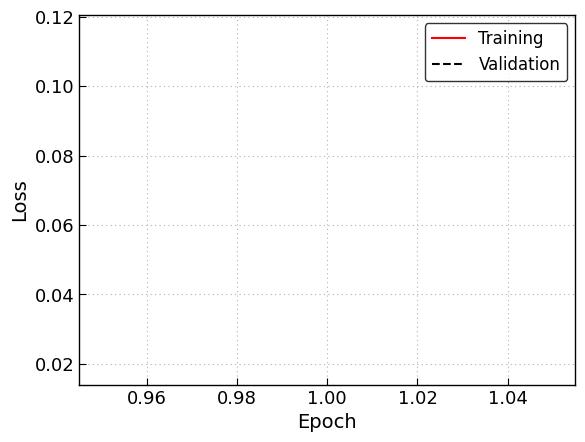

In [14]:

import callbacks as cb


# Define the callbacks
callbacks = [
    keras.callbacks.LearningRateScheduler(cb.lrschedule),
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/RPM_H_test.keras",
        monitor="val_mean_absolute_error",
        save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=25),
    cb.LossHistory()]


# Train the model
model.fit(
    trainingGenerator,
    validation_data=validationGenerator,
    epochs=400,
    callbacks=callbacks
)



## Quick test

In [15]:

#model.save('../../models/RPM_H.keras') 
#model = keras.models.load_model("../../models/RPM_H.keras")

testGenerator = DataGeneratorTwoType(simData["test"], **generatorOptions)
test_metrics = model.evaluate(testGenerator)

Initialized DataGenerator with 1000 simulations,
yielding up to 789984 samples in batches of 128
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0352 - mean_absolute_error: 0.1714


## See the predicted correlation function of test set

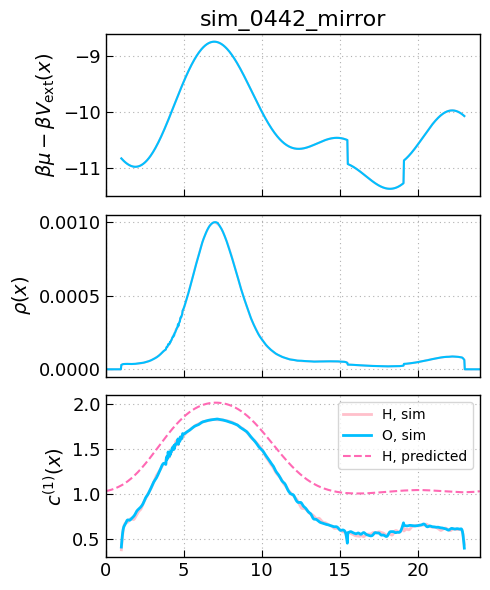

In [23]:



def generate_windows(array, bins, mode="wrap"):

    padded_array = np.pad(array, bins, mode=mode)
    windows = np.empty((len(array), 2 * bins + 1))
    for i in range(len(array)):
        windows[i] = padded_array[i:i + 2 * bins + 1]
    return windows


def c1H(model, rho_H, rho_O, input_bins=667):


    window_bins = (input_bins - 1) // 2
    rhoH_windows = generate_windows(rho_H, window_bins).reshape(rho_H.shape[0], input_bins, 1)
    rhoO_windows = generate_windows(rho_O, window_bins).reshape(rho_O.shape[0], input_bins, 1)

    c1H_result = model.predict_on_batch([rhoH_windows, rhoO_windows]).flatten()
    return c1H_result




# Combine all tests simulations into one list
all_test_simulations = []
for category in ['test']:
    all_test_simulations.extend(list(simData[category].keys()))


# Select a random simulation
random_sim = random.choice(all_test_simulations)
#random_sim = 'sim_2401'
# Determine which category the random simulation belongs to
category = next(cat for cat in simData if random_sim in simData[cat])


# Get the data for the random simulation
data = simData[category][random_sim]

# Extract z, rho, muloc, and c1
xbins = data['xbins']
rho_O = data['rho_O']
muloc_O = data['muloc_O']
c1_O = data['c1_O']
rho_H = data['rho_H']
muloc_H = data['muloc_H']
c1_H = data['c1_H']

# Plot muloc(z), rho(z), and c1(z)
fig, ax = plt.subplots(3, 1, figsize=(5,6), sharex='all')


ax[0].plot(xbins, muloc_H, label='H', color='pink')
ax[0].plot(xbins, muloc_O, label='O', color='deepskyblue')

ax[0].set_ylabel(r'$\beta\mu - \beta V_{\mathrm{ext}}(x)$')
ax[0].set_title(f'{random_sim}')

ax[1].plot(xbins, rho_H, label='H', color='pink')
ax[1].plot(xbins, rho_O, label='O', color='deepskyblue')

ax[2].plot(xbins, c1_H, label='H, sim', color='pink', lw=2)
ax[2].plot(xbins, c1_O, label='O, sim', color='deepskyblue', lw=2)

c1_H_pred = c1H(model, rho_H, rho_O)

ax[2].plot(xbins, c1_H_pred, label='H, predicted', color='hotpink', ls='--')


ax[1].set_ylabel(r'$\rho(x)$')
ax[2].set_ylabel(r'$c^\mathrm{(1)}(x)$')

ax[2].legend()
ax[2].set_xlim(0, 24)

place(ax[1])
place(ax[0])
place(ax[2])

plt.show()